In [1]:
import pandas as pd
import numpy as np
import yaml
import pycountry
import pycountry_convert as pc
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_swissre = pd.read_csv('./data/economic_weighted.csv', parse_dates=['date']).set_index('date')

iso_codes = ['AUT','BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'FRA', 'DEU', 'GRC', 'HUN', 'IRL', 'ITA', 'LVA', 'LTU', 'LUX', 'MLT', 'NLD', 'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP', 'SWE', 'GBR', 'CHE', 'NOR']

data_swissre = data_swissre[data_swissre['iso_code'].isin(iso_codes)]

/Users/francescoposa/opt/anaconda3/envs/personal/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (70,71,72,73,74,75,76,77,78) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


# Selecting columns for the first model

In [3]:
with open('config/economic_features.yaml', 'r', encoding='utf-8') as file:
    swissre_features = yaml.load(file, Loader=yaml.FullLoader)

In [4]:
columns_to_use= swissre_features['main'] +\
            swissre_features['demography'] +\
            swissre_features['sanitary'] +\
            swissre_features['weather'] +\
            swissre_features['economic'] +\
            swissre_features['policies']+\
            swissre_features['outcome']
            #swissre_features['vaccines'] +\

rep_rate = 'epiforecasts_effective_reproduction_number_median'

In [5]:
df = data_swissre[columns_to_use].copy()
df.columns

Index(['name', 'iso_code', 'cases', 'weight',
       'epiforecasts_effective_reproduction_number_median',
       'total_population_all', 'total_population_below_1',
       'total_population_1_to_4', 'total_population_5_to_14',
       'total_population_15_to_24', 'total_population_25_to_34',
       'total_population_35_to_54', 'total_population_55_to_74',
       'total_population_above_75', 'population_percentage_over_60',
       'hospital_beds_per_1000', 'physicians_per_1000', 'nurses_per_1000',
       'maxtempC', 'mintempC', 'tempC', 'FeelsLikeC', 'humidity', 'pressure',
       'HeatIndexC', 'uvIndex', 'totalSnow_cm', 'sunHour', 'windspeedKmph',
       'precipMM', 'unemployment_rate_2021_09_30',
       'unemployment_rate_2021_12_31', 'unemployment_rate_2019_03_31',
       'unemployment_rate_2019_06_30', 'unemployment_rate_2019_09_30',
       'unemployment_rate_2019_12_31', 'gdp_2019_03_31', 'gdp_2019_06_30',
       'gdp_2019_09_30', 'gdp_2019_12_31', 'gdp_2020_03_31', 'gdp_2020_06_30'

In [6]:
# Taking the data starting from the 1st of april. ALTERNATIVE: use days since outbreak
df = df[df.index >= '2020-04-01'].sort_index() #

In [7]:
# Filtering for valid countries: 
def filter_valid_countries(data, min_ratio):
    iso_codes = []
    for iso_code in data.iso_code.unique():
        data_country = data[data.iso_code == iso_code]['epiforecasts_effective_reproduction_number_median'].dropna()
        n_values = data_country.shape[0]

    # If rows exist for that country with a valid r_estim value
        if n_values > 0:
            n_days = (data_country.index[-1] - data_country.index[0]).days + 1
            #print(n_days)
            ratio = n_values / n_days

            if ratio > min_ratio:
                iso_codes.append(iso_code)
            
    return data[data['iso_code'].isin(iso_codes)]

df = filter_valid_countries(df, 0.9)

In [8]:
print(f"Number of countries: {len(df.iso_code.unique())}")

Number of countries: 30


In [9]:
# Putting NaN where the estimated reproduction number is larger than 4
df[rep_rate] = np.where(df[rep_rate] >= 4, np.nan, df[rep_rate])

In [10]:
# Shifting the reproduction rate by 11 days for each country
df['date_index'] = df.index
df = df.sort_values(by = ['iso_code', 'date_index'])
df['shifted_r_estim'] = df[rep_rate]

In [11]:
# retaining only the countries that exceeded 2000 casese
iso_codes = list(df[df['cases'] > 2000]['iso_code'].unique())
df = df[df['iso_code'].isin(iso_codes)]
print(f"Number of countries: {len(df.iso_code.unique())}")

Number of countries: 30


In [12]:
# The dataset does not include this data, while it is available
df.loc[df['iso_code'] == 'CYP', 'population_percentage_over_60'] = 19.79

# Training the first model

In [13]:
from classes.context import Context
from classes.pipeline import Pipeline
from classes.plot import Plot
import matplotlib.patches as mpatches

Global seed set to 42
Global seed set to 42


Training the model...



Global seed set to 42
GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name     | Type   | Params
------------------------------------
0 | lstm_1   | LSTM   | 2.6 K 
1 | linear_1 | Linear | 1.6 K 
2 | linear_2 | ReLU   | 0     
3 | mixed_1  | Linear | 1.1 K 
4 | mixed_2  | ReLU   | 0     
5 | mixed_3  | Linear | 16    
6 | mixed_4  | ReLU   | 0     
------------------------------------
5.2 K     Trainable params
0         Non-trainable params
5.2 K     Total params
0.021     Total estimated model params size (MB)
The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machin

...........................

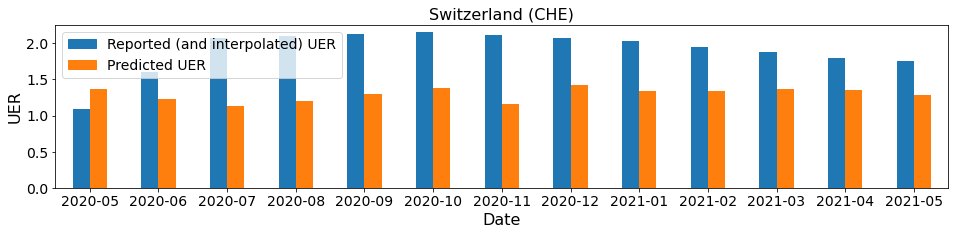

In [14]:
final_iso_code = 'CHE'

# Final training colums
train_cols= swissre_features['demography'] +\
            swissre_features['sanitary'] +\
            swissre_features['economic'] +\
            swissre_features['policies']+ ['shifted_r_estim']# +\
              #swissre_features['weather'] # swissre_features['vaccines']+\

final_train_cols = [col for col in train_cols if not df[df['iso_code'] == final_iso_code][col].isnull().all()]
final_train_cols = [col for col in final_train_cols if not df[col].std() == 0]

context = Context()
pipeline = Pipeline(df, final_train_cols, 'unemployment_rate_idx', final_iso_code, 28, context, 'weight') #shifted_r_estim

pipeline.fit_pipeline(save_model=False)

predictions = pipeline.predict()

test_indices = df['iso_code'] == final_iso_code
index = df.loc[test_indices].index
ground = df.loc[test_indices]['unemployment_rate_idx']
error_curve = np.abs(ground - predictions)

df2 = pd.DataFrame({'index': index, 'ground': ground, 'pred': predictions, 'error': error_curve}).sort_values(by = 'index')
df2 = df2[(df2['index'] >= '2020-05-01') & (df2['index'].dt.day == 1)]

df2['index'] = df2['index'].dt.strftime('%Y-%m')

df2.plot.bar(x = 'index', y = ['ground', 'pred'], rot = 0, fontsize=14, legend=False, figsize = (16, 3))

pre_patch = mpatches.Patch(color=(1.0, 0.4980392156862745, 0.054901960784313725, 1.0), label='Predicted UER')
ground_patch = mpatches.Patch(color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), label='Reported (and interpolated) UER')
plt.legend(handles=[ground_patch, pre_patch], fontsize=14)

plt.title("Switzerland (CHE)", fontsize=16)
plt.xlabel("Date", fontsize=16);
plt.ylabel("UER", fontsize=16);